Goal: train a multi-modal model to classify images (high/medium/low selling) combining sales dataset and images

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

In [ ]:
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

In [ ]:
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub

OK


In [ ]:
!apt-get update

In [ ]:
!sudo apt-get install cuda-9.0

In [ ]:
!nvcc --version #check the installation

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [ ]:
!pip install --upgrade pip

# NVIDIA CUDA 12 installation
!pip install --upgrade "jax[cuda12]"

# Data loading and preprocessing

###1. Sales data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings
from scipy import stats
#import scipy as scipy
import torch
import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
sales = pd.read_csv("/content/drive/MyDrive/Visuelle/sales.csv")
sales.head()

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,2,3,4,5,6,7,8,9,10,11
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
sales_cleaned = sales.drop(columns=['Unnamed: 0'])

# Summarizing the sales columns
sales_columns = sales_cleaned.columns[9:]
sales_cleaned['total_sales'] = sales[sales_columns].sum(axis=1)

In [ ]:
# Drop the sales columns '0' to '11'
sales_cleaned.drop(columns=[str(i) for i in range(12)], inplace=True)
sales_cleaned.head()

,external_code,retail,season,category,color,image_path,fabric,release_date,restock,total_sales
0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,11.0
1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,7.0
2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,11.0
3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,6.0
4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,13.0


In [ ]:
data = sales_cleaned.drop(columns=['retail', 'season', 'release_date', 'restock'])
# Group by 'external_code' and aggregate the columns
data = data.groupby('external_code').agg({
    'category': 'first',  # Retain the first occurrence (all values should be the same for a given external_code)
    'color': 'first',
    'image_path': 'first',
    'fabric': 'first',
    'total_sales': 'sum'  # Sum the total sales for each unique external_code
}).reset_index()

data.head()

,external_code,category,color,image_path,fabric,total_sales
0,1,long sleeve,violet,PE17/00001.png,acrylic,66.0
1,2,long sleeve,violet,PE17/00002.png,acrylic,525.0
2,3,culottes,blue,PE17/00003.png,scuba crepe,26.0
3,4,long sleeve,yellow,PE17/00004.png,acrylic,90.0
4,5,long sleeve,grey,PE17/00005.png,acrylic,171.0


####1.1 Exploring labels data

Multiple textual tags related to each product’s visual attributes are available. These tags have been extracted with diverse procedures or chosen by hand, carefully validated by the Nuna Lie team (https://arxiv.org/pdf/2204.06972v1)

In [ ]:
category_labels = torch.load("/content/drive/MyDrive/Visuelle/category_labels.pt")
pprint.pprint(category_labels)

{'capris': 28,
 'cloak': 27,
 'culottes': 0,
 'doll dress': 11,
 'drop sleeve': 2,
 'gitana skirt': 21,
 'jumpsuit': 20,
 'kimono dress': 17,
 'long cardigan': 25,
 'long coat': 14,
 'long dress': 10,
 'long duster': 23,
 'long skirt': 26,
 'long sleeve': 3,
 'longuette skirt': 30,
 'maxi': 19,
 'medium cardigan': 18,
 'medium coat': 4,
 'medium duster': 29,
 'miniskirt': 6,
 'patterned top': 16,
 'printed shirt': 24,
 'sheath dress': 7,
 'shirt dress': 15,
 'short cardigan': 13,
 'short coat': 22,
 'short sleeves': 9,
 'shorts': 1,
 'sleeveless': 8,
 'solid color top': 5,
 'trapeze dress': 12}


In [ ]:
color_labels = torch.load("/content/drive/MyDrive/Visuelle/color_labels.pt")
pprint.pprint(color_labels)

{'black': 2,
 'blue': 7,
 'brown': 4,
 'green': 3,
 'grey': 0,
 'orange': 9,
 'red': 5,
 'violet': 8,
 'white': 1,
 'yellow': 6}


In [ ]:
fabric_labels = torch.load("/content/drive/MyDrive/Visuelle/fabric_labels.pt")
pprint.pprint(fabric_labels)

{'acrylic': 7,
 'angora': 48,
 'bengaline': 37,
 'cady': 20,
 'chambree': 30,
 'chanel': 52,
 'chine crepe': 50,
 'cloth': 4,
 'cotton': 23,
 'crepe': 3,
 'dainetto': 40,
 'dark jeans': 18,
 'devore': 5,
 'embossed': 6,
 'faux leather': 32,
 'flamed': 56,
 'fluid': 44,
 'fluid polyviscous': 21,
 'foam rubber': 24,
 'frise': 15,
 'fur': 36,
 'georgette': 8,
 'goose': 58,
 'heavy jeans': 34,
 'hron': 49,
 'ity': 46,
 'jacquard': 39,
 'lace': 26,
 'light jeans': 27,
 'linen': 35,
 'lurex': 19,
 'macrame': 41,
 'marocain': 11,
 'matte jersey': 14,
 'milano stitch': 38,
 'mohair': 31,
 'muslin cotton or silk': 25,
 'mutton': 42,
 'nice': 9,
 'nylon': 51,
 'ottoman': 45,
 'paillettes': 33,
 'piquet': 53,
 'plisse': 43,
 'plumetis': 47,
 'plush': 54,
 'polyviscous': 0,
 'satin cotton': 1,
 'scottish': 57,
 'scuba crepe': 16,
 'shiny jersey': 22,
 'silky satin': 17,
 'tactel': 55,
 'technical': 2,
 'tencel': 28,
 'tulle': 12,
 'velvet': 13,
 'viscose twill': 29,
 'webbing': 10}


###2. Images

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_folder = '/content/drive/MyDrive/Visuelle/images'

# Define image data generator with preprocessing
image_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize images
    rotation_range=20,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Load images from directory, using class_mode=None since we're not using subfolder names as labels
image_generator = image_datagen.flow_from_directory(
    directory=image_folder,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode=None,  # Since subfolders don't represent classes, set class_mode to None
    shuffle=True
)

Found 5355 images belonging to 6 classes.


In [ ]:
print(image_generator.labels)

[0 0 0 ... 5 5 5]


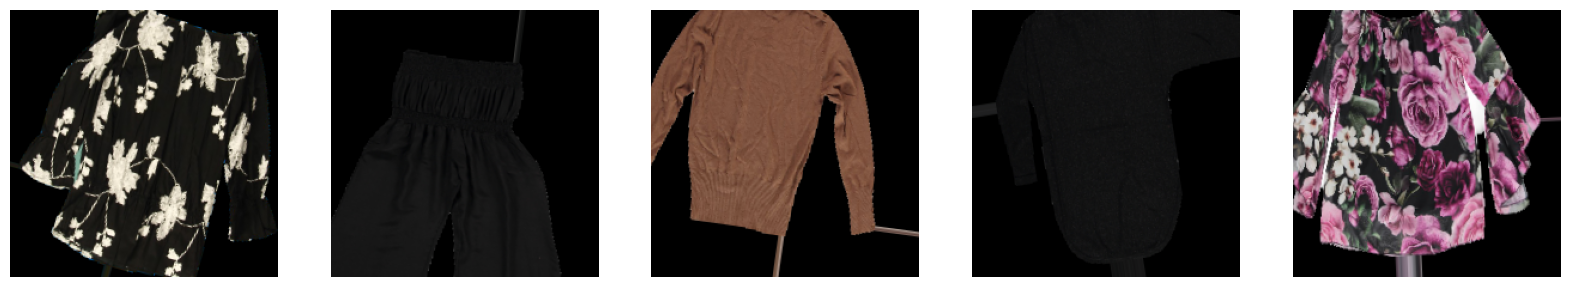

In [ ]:
# Display some images
def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20,20))
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Fetch a batch of images
images = next(image_generator)

plot_images(images[:5])

In [ ]:
# If it returns a shape with only the image batch size and dimensions (e.g., (32, 224, 224, 3)), it confirms that no labels are being assigned.
print("Shape of the batch:", images.shape)

Shape of the batch: (32, 224, 224, 3)


In [ ]:
print("Category Labels:", category_labels)
print("Color Labels:", color_labels)
print("Fabric Labels:", fabric_labels)

Category Labels: {'culottes': 0, 'shorts': 1, 'drop sleeve': 2, 'long sleeve': 3, 'medium coat': 4, 'miniskirt': 6, 'sheath dress': 7, 'sleeveless': 8, 'short sleeves': 9, 'long dress': 10, 'doll dress': 11, 'trapeze dress': 12, 'short cardigan': 13, 'long coat': 14, 'shirt dress': 15, 'kimono dress': 17, 'medium cardigan': 18, 'maxi': 19, 'gitana skirt': 21, 'short coat': 22, 'long duster': 23, 'long cardigan': 25, 'long skirt': 26, 'cloak': 27, 'capris': 28, 'medium duster': 29, 'longuette skirt': 30, 'jumpsuit': 20, 'patterned top': 16, 'solid color top': 5, 'printed shirt': 24}
Color Labels: {'grey': 0, 'white': 1, 'black': 2, 'green': 3, 'brown': 4, 'red': 5, 'yellow': 6, 'blue': 7, 'violet': 8, 'orange': 9}
Fabric Labels: {'polyviscous': 0, 'satin cotton': 1, 'technical': 2, 'crepe': 3, 'cloth': 4, 'devore': 5, 'embossed': 6, 'acrylic': 7, 'georgette': 8, 'nice': 9, 'webbing': 10, 'marocain': 11, 'tulle': 12, 'velvet': 13, 'matte jersey': 14, 'frise': 15, 'scuba crepe': 16, 'silk

In [ ]:
data.head()

,external_code,category,color,image_path,fabric,total_sales
0,1,long sleeve,violet,PE17/00001.png,acrylic,66.0
1,2,long sleeve,violet,PE17/00002.png,acrylic,525.0
2,3,culottes,blue,PE17/00003.png,scuba crepe,26.0
3,4,long sleeve,yellow,PE17/00004.png,acrylic,90.0
4,5,long sleeve,grey,PE17/00005.png,acrylic,171.0


In [ ]:
# we have already the mapping in the csv file, we can encode those for the model

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
import scipy
print(scipy.__version__)

1.14.1


In [ ]:
# Initialize label encoders
category_encoder = LabelEncoder()
color_encoder = LabelEncoder()
fabric_encoder = LabelEncoder()

# Fit and transform each label column to numerical indices
data['category_encoded'] = category_encoder.fit_transform(data['category'])
data['color_encoded'] = color_encoder.fit_transform(data['color'])
data['fabric_encoded'] = fabric_encoder.fit_transform(data['fabric'])

# Now let's one-hot encode these encoded labels for input to the model
onehot_encoder = OneHotEncoder(sparse_output=False)

category_onehot = onehot_encoder.fit_transform(data['category_encoded'].values.reshape(-1, 1))
color_onehot = onehot_encoder.fit_transform(data['color_encoded'].values.reshape(-1, 1))
fabric_onehot = onehot_encoder.fit_transform(data['fabric_encoded'].values.reshape(-1, 1))

print("Category One-Hot Encoding:\n", category_onehot)
print("Color One-Hot Encoding:\n", color_onehot)
print("Fabric One-Hot Encoding:\n", fabric_onehot)

Category One-Hot Encoding:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Color One-Hot Encoding:
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Fabric One-Hot Encoding:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#Preparing combined data (text + images)

In [ ]:
# Combine the encoded label data into a single feature set
label_features = np.concatenate([category_onehot, color_onehot, fabric_onehot], axis=1)

In [ ]:
# Define thresholds for sales categories (low, medium, high)
data['sales_category'] = pd.qcut(data['total_sales'], q=3, labels=['low', 'medium', 'high'])

# Encode sales category labels to integers
sales_category_encoder = {'low': 0, 'medium': 1, 'high': 2}
data['sales_category_encoded'] = data['sales_category'].map(sales_category_encoder)

data.head()

,external_code,category,color,image_path,fabric,total_sales,category_encoded,color_encoded,fabric_encoded,sales_category,sales_category_encoded
0,1,long sleeve,violet,PE17/00001.png,acrylic,66.0,11,7,0,low,0
1,2,long sleeve,violet,PE17/00002.png,acrylic,525.0,11,7,0,high,2
2,3,culottes,blue,PE17/00003.png,scuba crepe,26.0,1,1,49,low,0
3,4,long sleeve,yellow,PE17/00004.png,acrylic,90.0,11,9,0,medium,1
4,5,long sleeve,grey,PE17/00005.png,acrylic,171.0,11,4,0,medium,1


Let's assign category, color, fabric, and sales_category_encoded to images as labels, including these attributes as additional features along with the image data.

In [ ]:
image_filenames = image_generator.filenames

# Create a mapping from image filenames to sales data
data['image_filename'] = data['image_path'].apply(lambda x: os.path.join(x.split('/')[0], x.split('/')[-1]))

# Align image filenames with sales data rows
aligned_sales_data = data.set_index('image_filename').loc[image_filenames].reset_index()

# Combine numerical and encoded categorical features
sales_features = aligned_sales_data[['external_code', 'total_sales']].values
combined_sales_features = np.concatenate([sales_features, label_features], axis=1)

# Extract sales category as labels for classification task
sales_labels = aligned_sales_data['sales_category_encoded'].values

print("Combined Sales Features Shape:", combined_sales_features.shape)
print("Sales Labels Shape:", sales_labels.shape)

Combined Sales Features Shape: (5355, 98)
Sales Labels Shape: (5355,)


In [ ]:
data.head()

,external_code,category,color,image_path,fabric,total_sales,category_encoded,color_encoded,fabric_encoded,sales_category,sales_category_encoded,image_filename
0,1,long sleeve,violet,PE17/00001.png,acrylic,66.0,11,7,0,low,0,PE17/00001.png
1,2,long sleeve,violet,PE17/00002.png,acrylic,525.0,11,7,0,high,2,PE17/00002.png
2,3,culottes,blue,PE17/00003.png,scuba crepe,26.0,1,1,49,low,0,PE17/00003.png
3,4,long sleeve,yellow,PE17/00004.png,acrylic,90.0,11,9,0,medium,1,PE17/00004.png
4,5,long sleeve,grey,PE17/00005.png,acrylic,171.0,11,4,0,medium,1,PE17/00005.png


Let's extract now image features

In [ ]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load pre-trained ResNet50 model without top classification layer
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

image_features = resnet_model.predict(image_generator)

print("Image Features Shape:", image_features.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 1323s 8s/step
Image Features Shape: (5355, 2048)


##Bulding multi-modal model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
image_features_train, image_features_test, sales_features_train, sales_features_test, labels_train, labels_test = train_test_split(
    image_features, combined_sales_features, sales_labels, test_size=0.2, random_state=42)

# Convert features and labels to tensors for training with TensorFlow
image_features_train_tensor = tf.convert_to_tensor(image_features_train, dtype=tf.float32)
image_features_test_tensor = tf.convert_to_tensor(image_features_test, dtype=tf.float32)
sales_features_train_tensor = tf.convert_to_tensor(sales_features_train, dtype=tf.float32)
sales_features_test_tensor = tf.convert_to_tensor(sales_features_test, dtype=tf.float32)
labels_train_tensor = tf.convert_to_tensor(labels_train, dtype=tf.float32)
labels_test_tensor = tf.convert_to_tensor(labels_test, dtype=tf.float32)

In [ ]:
# Ensure labels are in the correct shape and data type
labels_train_tensor = tf.convert_to_tensor(labels_train, dtype=tf.int32)
labels_test_tensor = tf.convert_to_tensor(labels_test, dtype=tf.int32)

print("Corrected Labels Train Tensor Shape:", labels_train_tensor.shape)
print("Corrected Labels Test Tensor Shape:", labels_test_tensor.shape)

Corrected Labels Train Tensor Shape: (4284,)
Corrected Labels Test Tensor Shape: (1071,)


In [ ]:
# Ensure labels are correctly shaped and are integers for sparse categorical crossentropy
labels_train_tensor = tf.reshape(labels_train_tensor, [-1])
labels_test_tensor = tf.reshape(labels_test_tensor, [-1])

In [ ]:
print("Image Features Train Tensor Shape:", image_features_train_tensor.shape)
print("Sales Features Train Tensor Shape:", sales_features_train_tensor.shape)
print("Labels Train Tensor Shape:", labels_train_tensor.shape)

Image Features Train Tensor Shape: (4284, 2048)
Sales Features Train Tensor Shape: (4284, 98)
Labels Train Tensor Shape: (4284,)


Creating three different models with varying architectures to compare their performances.

In [ ]:
# simplest architecture.

def build_baseline_model(image_input_shape, sales_input_shape):
    # Define inputs with correct shapes
    image_input = Input(shape=(image_input_shape,))
    sales_input = Input(shape=(sales_input_shape,))

    # Simple model architecture
    image_dense = Dense(128, activation='relu')(image_input)
    sales_dense = Dense(64, activation='relu')(sales_input)

    concat = Concatenate()([image_dense, sales_dense])
    output = Dense(3, activation='softmax')(concat)

    model = Model(inputs=[image_input, sales_input], outputs=output)
    # Update metrics names
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# more layers and neurons for potentially better learning.

def build_deeper_model(image_input_shape, sales_input_shape):
    # Define inputs
    image_input = Input(shape=(image_input_shape,))
    sales_input = Input(shape=(sales_input_shape,))

    # Dense layers for each input
    image_dense = Dense(256, activation='relu')(image_input)
    sales_dense = Dense(128, activation='relu')(sales_input)

    # Add dropout layers to prevent overfitting
    image_dropout = Dropout(0.5)(image_dense)
    sales_dropout = Dropout(0.5)(sales_dense)

    # Concatenate all features
    concat = Concatenate()([image_dropout, sales_dropout])

    # Additional dense layer for combined features
    dense = Dense(128, activation='relu')(concat)
    output = Dense(3, activation='softmax')(dense)

    model = Model(inputs=[image_input, sales_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# wider layers to capture more complex relationships

def build_wide_model(image_input_shape, sales_input_shape):
    # Define inputs
    image_input = Input(shape=(image_input_shape,))
    sales_input = Input(shape=(sales_input_shape,))

    # Dense layers for each input with more neurons
    image_dense = Dense(512, activation='relu')(image_input)
    sales_dense = Dense(256, activation='relu')(sales_input)

    # Add dropout layers to prevent overfitting
    image_dropout = Dropout(0.5)(image_dense)
    sales_dropout = Dropout(0.5)(sales_dense)

    # Concatenate all features
    concat = Concatenate()([image_dropout, sales_dropout])

    # Additional dense layer for combined features
    dense = Dense(256, activation='relu')(concat)
    output = Dense(3, activation='softmax')(dense)

    model = Model(inputs=[image_input, sales_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Confirm batch sizes match
print(image_features_train_tensor.shape[0])
print(sales_features_train_tensor.shape[0])
print(labels_train_tensor.shape[0])

4284
4284
4284


In [ ]:
image_input_shape = image_features_train_tensor.shape[1]
sales_input_shape = sales_features_train_tensor.shape[1]

b_model = build_baseline_model(image_input_shape, sales_input_shape)
d_model = build_deeper_model(image_input_shape, sales_input_shape)
w_model = build_wide_model(image_input_shape, sales_input_shape)

# List to store models and their names
models = [
    ('Baseline Model', b_model),
    ('Deeper Model', d_model),
    ('Wide Model', w_model)
]

In [ ]:
# Train each model
for name, model in models:
    print(f"Training {name}...")
    model.fit(
        x=[image_features_train_tensor, sales_features_train_tensor],
        y=labels_train_tensor,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

Training Baseline Model...
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5112 - loss: 10.7112 - val_accuracy: 0.9032 - val_loss: 0.2136
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8999 - loss: 0.2412 - val_accuracy: 0.7993 - val_loss: 0.6397
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9041 - loss: 0.2499 - val_accuracy: 0.9253 - val_loss: 0.1631
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.3503 - val_accuracy: 0.9673 - val_loss: 0.1065
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8985 - loss: 0.2636 - val_accuracy: 0.9697 - val_loss: 0.0966
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.1457 - val_accuracy: 0.9510 - val_loss: 0.1105
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9368 - loss: 0.1754 - val_accuracy: 0.8786 - val_loss: 0.8618
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8657 - lo

In [ ]:
results_df = pd.DataFrame(columns=['Model', 'Test Loss', 'Test Accuracy'])

for name, model in models:
    print(f"Evaluating {name}...")
    eval_result = model.evaluate([image_features_test_tensor, sales_features_test_tensor], labels_test_tensor, verbose=0)

    # Create a new row as a DataFrame
    new_row = pd.DataFrame({
        'Model': [name],
        'Test Loss': [eval_result[0]],
        'Test Accuracy': [eval_result[1]]
    })

    # Concatenate the new row to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

Evaluating Baseline Model...
Evaluating Deeper Model...
Evaluating Wide Model...


In [ ]:
results_df.head()

,Model,Test Loss,Test Accuracy
0,Baseline Model,0.923969,0.826331
1,Deeper Model,0.175090,0.941176
2,Wide Model,0.160415,0.953315


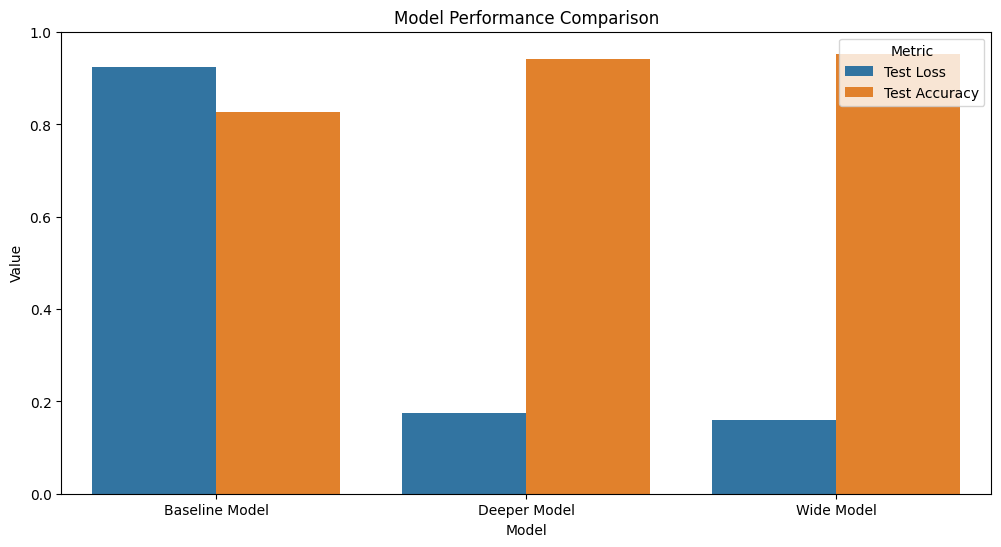

In [ ]:
# Reshape the DataFrame for easier plotting
results_melted = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=results_melted)
plt.title('Model Performance Comparison')
plt.ylabel('Value')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.show()

- Test Loss:
Represents the loss value on the test dataset. A lower loss indicates a better fit of the model to the test data.
- Test Accuracy:
Represents the accuracy of the model on the test dataset. A higher accuracy indicates that the model makes more correct predictions.

Best model:<br>
- Deeper Model: if minimizing errors (lowering loss) is more important
- Wide Model: if maximizing correct predictions (higher accuracy) is more important
> we choose accuracy over loss so we'll continue with the wide model

##### Hyperparameters tuning

In [ ]:
!pip install keras-tuner

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from keras_tuner import HyperModel

In [ ]:
# Define the hypermodel
class WideModelHyperModel(HyperModel):
    def __init__(self, image_input_shape, sales_input_shape):
        self.image_input_shape = image_input_shape
        self.sales_input_shape = sales_input_shape

    def build(self, hp):
        # Define inputs
        image_input = Input(shape=(self.image_input_shape,))
        sales_input = Input(shape=(self.sales_input_shape,))

        # Hyperparameters to tune
        image_units = hp.Int('image_units', min_value=128, max_value=512, step=128)
        sales_units = hp.Int('sales_units', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

        # Dense layers for each input with tunable neurons
        image_dense = Dense(image_units, activation='relu')(image_input)
        sales_dense = Dense(sales_units, activation='relu')(sales_input)

        # Add dropout layers to prevent overfitting
        image_dropout = Dropout(dropout_rate)(image_dense)
        sales_dropout = Dropout(dropout_rate)(sales_dense)

        # Concatenate all features
        concat = Concatenate()([image_dropout, sales_dropout])

        # Additional dense layer for combined features
        dense = Dense(256, activation='relu')(concat)
        output = Dense(3, activation='softmax')(dense)

        # Build the model
        model = Model(inputs=[image_input, sales_input], outputs=output)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    WideModelHyperModel(image_input_shape=image_input_shape, sales_input_shape=sales_input_shape),
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to be built and fit for each trial
    directory='my_dir',
    project_name='wide_model_tuning'
)

In [ ]:
tuner.search(
    x=[image_features_train_tensor, sales_features_train_tensor],
    y=labels_train_tensor,
    epochs=10,
    validation_split=0.2
)

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.97782963514328

Best val_accuracy So Far: 0.97782963514328
Total elapsed time: 00h 01m 34s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the image input layer is {best_hps.get('image_units')}.
The optimal number of units in the sales input layer is {best_hps.get('sales_units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
""")


The optimal number of units in the image input layer is 512.
The optimal number of units in the sales input layer is 128.
The optimal dropout rate is 0.2.



In [ ]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x=[image_features_train_tensor, sales_features_train_tensor],
    y=labels_train_tensor,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5299 - loss: 23.7578 - val_accuracy: 0.6826 - val_loss: 6.4239
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 6.2548 - val_accuracy: 0.8471 - val_loss: 1.2918
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8347 - loss: 2.6914 - val_accuracy: 0.8390 - val_loss: 3.6359
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8354 - loss: 2.7505 - val_accuracy: 0.8553 - val_loss: 2.0089
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 2.9476 - val_accuracy: 0.9183 - val_loss: 0.4710
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8919 - loss: 1.4358 - val_accuracy: 0.9078 - val_loss: 1.0158
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8972 - loss: 1.1450 - val_accuracy: 0.9498 - val_loss: 0.2495
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8949 - loss: 1.1634 - val_accuracy: 

In [ ]:
performance = best_model.evaluate([image_features_test_tensor, sales_features_test_tensor], labels_test_tensor, verbose=0)
print(f"Test Loss: {performance[0]}, Test Accuracy: {performance[1]}")

Test Loss: 0.547476053237915, Test Accuracy: 0.9458450078964233


In [ ]:
# Make predictions on the test dataset
predictions = best_model.predict([image_features_test_tensor, sales_features_test_tensor])

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Ensure labels_test_tensor is not a tensor, but a NumPy array for plotting
actual_classes = labels_test_tensor.numpy()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Calculate precision, recall, and f1-score for each class
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(actual_classes, predicted_classes)
print("Accuracy: ", accuracy)
print( "Precision: ", precision)
print("Recall: ", recall)
print("f1: ", f1)

Accuracy:  0.945845004668534
Precision:  0.9513357968165814
Recall:  0.945845004668534
f1:  0.9452867413313127


<Figure size 800x600 with 0 Axes>

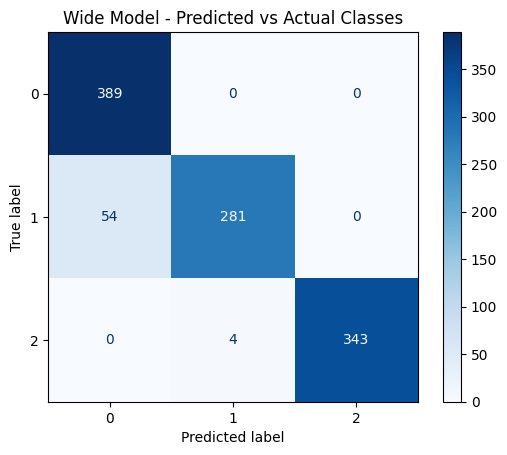

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues', values_format='d')
plt.title('Wide Model - Predicted vs Actual Classes')
plt.show();

**Tune also deeper model**

In [ ]:
# Define the hypermodel for the Deeper Model
class DeeperModelHyperModel(HyperModel):
    def __init__(self, image_input_shape, sales_input_shape):
        self.image_input_shape = image_input_shape
        self.sales_input_shape = sales_input_shape

    def build(self, hp):
        # Define inputs
        image_input = Input(shape=(self.image_input_shape,))
        sales_input = Input(shape=(self.sales_input_shape,))

        # Hyperparameters to tune
        image_units_1 = hp.Int('image_units_1', min_value=128, max_value=512, step=128)
        image_units_2 = hp.Int('image_units_2', min_value=128, max_value=512, step=128)
        sales_units_1 = hp.Int('sales_units_1', min_value=64, max_value=256, step=64)
        sales_units_2 = hp.Int('sales_units_2', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

        # Define the model architecture with tunable layers
        image_dense_1 = Dense(image_units_1, activation='relu')(image_input)
        image_dropout = Dropout(dropout_rate)(image_dense_1)
        image_dense_2 = Dense(image_units_2, activation='relu')(image_dropout)

        sales_dense_1 = Dense(sales_units_1, activation='relu')(sales_input)
        sales_dropout = Dropout(dropout_rate)(sales_dense_1)
        sales_dense_2 = Dense(sales_units_2, activation='relu')(sales_dropout)

        # Concatenate all features
        concat = Concatenate()([image_dense_2, sales_dense_2])

        # Additional dense layer for combined features
        dense = Dense(256, activation='relu')(concat)
        output = Dense(3, activation='softmax')(dense)

        # Compile the model
        model = Model(inputs=[image_input, sales_input], outputs=output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model


In [ ]:
tuner_deeper = RandomSearch(
    DeeperModelHyperModel(image_input_shape=image_input_shape, sales_input_shape=sales_input_shape),
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train for each hyperparameter combination
    directory='deeper_model_tuning',
    project_name='deeper_model_tuning'
)

In [ ]:
tuner_deeper.search(
    x=[image_features_train_tensor, sales_features_train_tensor],
    y=labels_train_tensor,
    epochs=10,
    validation_split=0.2
)

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.9626604318618774

Best val_accuracy So Far: 0.9649941921234131
Total elapsed time: 00h 01m 51s


In [ ]:
best_hps_deeper = tuner_deeper.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first image input layer is {best_hps_deeper.get('image_units_1')}.
The optimal number of units in the second image input layer is {best_hps_deeper.get('image_units_2')}.
The optimal number of units in the first sales input layer is {best_hps_deeper.get('sales_units_1')}.
The optimal number of units in the second sales input layer is {best_hps_deeper.get('sales_units_2')}.
The optimal dropout rate is {best_hps_deeper.get('dropout_rate')}.
The optimal learning rate is {best_hps_deeper.get('learning_rate')}.
""")


The optimal number of units in the first image input layer is 128.
The optimal number of units in the second image input layer is 512.
The optimal number of units in the first sales input layer is 192.
The optimal number of units in the second sales input layer is 256.
The optimal dropout rate is 0.1.
The optimal learning rate is 0.008547485565344062.



In [ ]:
best_model_deeper = tuner_deeper.hypermodel.build(best_hps_deeper)
history_deeper = best_model_deeper.fit(
    x=[image_features_train_tensor, sales_features_train_tensor],
    y=labels_train_tensor,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5938 - loss: 84.2898 - val_accuracy: 0.9183 - val_loss: 0.1990
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.3557 - val_accuracy: 0.9102 - val_loss: 0.1904
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8556 - loss: 0.3394 - val_accuracy: 0.9288 - val_loss: 0.1696
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.2955 - val_accuracy: 0.9440 - val_loss: 0.1351
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9059 - loss: 0.2314 - val_accuracy: 0.7830 - val_loss: 0.6139
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8832 - loss: 0.2965 - val_accuracy: 0.8705 - val_loss: 0.2403
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8985 - loss: 0.2315 - val_accuracy: 0.9627 - val_loss: 0.1153
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9288 - loss: 0.1846 - val_accuracy: 

In [ ]:
performance_d = best_model_deeper.evaluate([image_features_test_tensor, sales_features_test_tensor], labels_test_tensor, verbose=0)
print(f"Deeper---Test Loss: {performance_d[0]}, Test Accuracy: {performance_d[1]}")
print(f"Wide---Test Loss: {performance[0]}, Test Accuracy: {performance[1]}")

Deeper---Test Loss: 0.1420184075832367, Test Accuracy: 0.9383753538131714
Wide---Test Loss: 0.547476053237915, Test Accuracy: 0.9458450078964233


In [ ]:
predictions_d = best_model_deeper.predict([image_features_test_tensor, sales_features_test_tensor])
# Convert predicted probabilities to class labels
predicted_classes_d = np.argmax(predictions_d, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
precision_d = precision_score(actual_classes, predicted_classes_d, average='weighted')
recall_d = recall_score(actual_classes, predicted_classes_d, average='weighted')
f1_d = f1_score(actual_classes, predicted_classes_d, average='weighted')
accuracy_d = accuracy_score(actual_classes, predicted_classes_d)
print("Accuracy: ", accuracy_d)
print( "Precision: ", precision_d)
print("Recall: ", recall_d)
print("f1: ", f1_d)

Accuracy:  0.938375350140056
Precision:  0.9432960126011906
Recall:  0.938375350140056
f1:  0.9384937482180169


<Figure size 800x600 with 0 Axes>

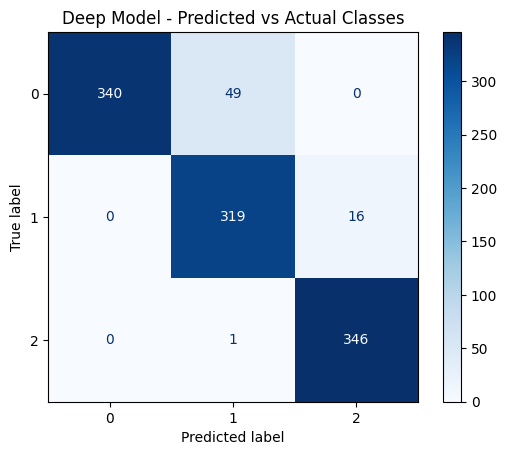

In [ ]:
conf_matrix_d = confusion_matrix(actual_classes, predicted_classes_d)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(conf_matrix_d).plot(cmap='Blues', values_format='d')
plt.title('Deep Model - Predicted vs Actual Classes')
plt.show();

In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Wide Model': [precision, recall, f1, accuracy],
    'Deep Model': [precision_d, recall_d, f1_d, accuracy_d]
})

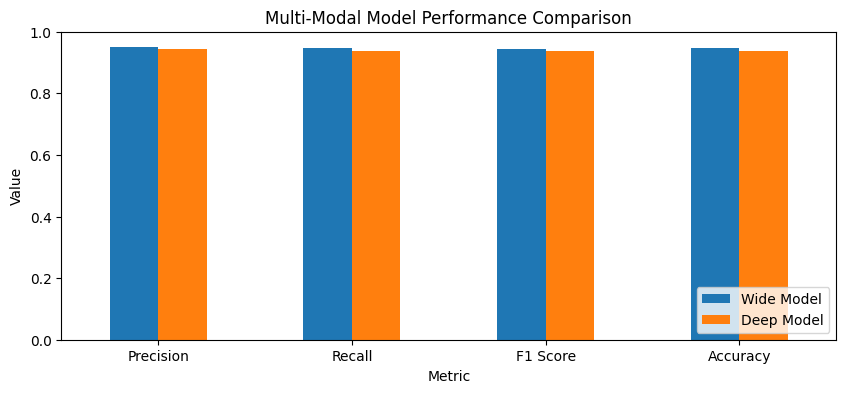

In [ ]:
metrics_df.set_index('Metric').plot(kind='bar', figsize=(10, 4))
plt.title('Multi-Modal Model Performance Comparison')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()